# PHYS3070: Buoyant Ball (Rising Ball)

Romain Beucher and Louis Moresi

This Jupyter notebook introduce Underworld, a research software solving the Stokes and Advection-Diffusion equation with applications to Earth's dynamics.

The example illustrate the principle of buoyancy. A ball is placed inside a container filled with a viscous liquid. The density of the ball is lower than the density of the surrounding fluid: the constrast creates an upward force and the ball rises. The example do not account for the effect of temperature on the density of the materials. We will explore this in the next example. 

## Import python tools

In [1]:
%matplotlib notebook
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Scaling

In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
temperature_diff = 500. * u.degK

characteristic_length = model_height
characteristic_time = characteristic_length / velocity
characteristic_mass = bodyforce * characteristic_length**2 * characteristic_time**2
characteristic_temperature = temperature_diff

GEO.scaling_coefficients["[length]"] = characteristic_length
GEO.scaling_coefficients["[time]"] = characteristic_time
GEO.scaling_coefficients["[mass]"] = characteristic_mass
GEO.scaling_coefficients["[temperature]"] = characteristic_temperature

# Geometry

We define a tank in 2-dimensions. The dimension of the tank is set to be 1m in height and 1m in width. The extent of the tank is defined using the `minCoord` and `maxCoord` arguments chosen in a way that the origin is located at the center of the tank. We define the number of elements used to discretise the domain.

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(-0.5 * u.m, -0.5 * u.m), 
                  maxCoord=(0.5 * u.m, 0.5 * u.m))

## Materials

The tank is filled with a viscous fluid (`background_fluid`).
A ball of colder / denser material (`ball`) is placed in the fluid 30 cm above the center of the tank (20cm from the top of the box.). The ball diameter is chosen to be 20cm.

In [5]:
background_fluid = Model.add_material(name="Background", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))

Disk = GEO.shapes.Disk(center=(0.,-30.*u.centimetre), radius=10 * u.centimetre)
ball = Model.add_material(name="Ball", shape=Disk)


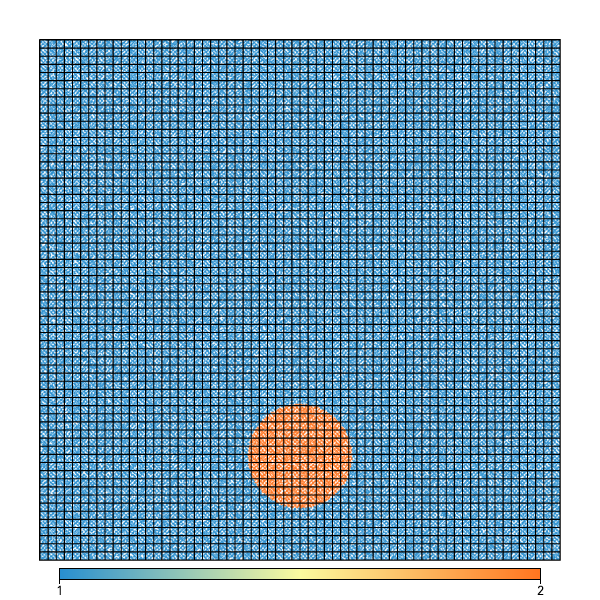

In [6]:
Fig1 = vis.Figure(figsize=(600,600))
Fig1.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig1.Mesh(Model.mesh)
Fig1.show()

### Material properties

In [7]:
background_fluid.density = 500 * u.kilogram / u.metre**3
background_fluid.viscosity = 1e6 * u.pascal * u.second

ball.viscosity = 1e6 * u.pascal * u.second
ball.density = 10 * u.kilogram / u.metre**3

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



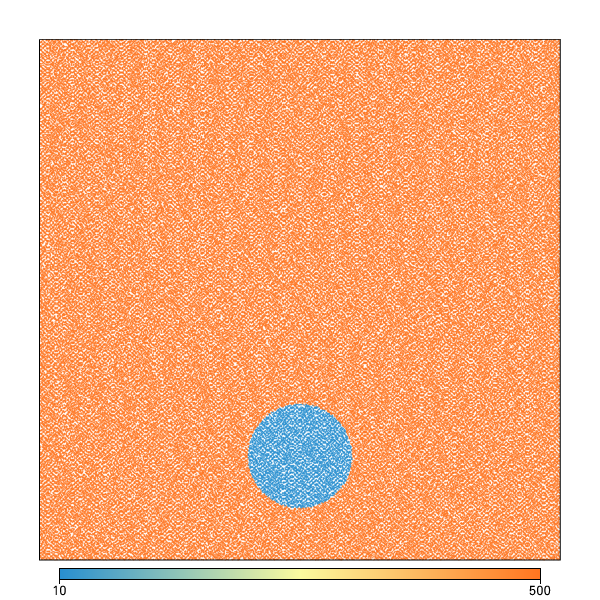

In [8]:
Fig = vis.Figure(figsize=(600,600))
Fig.Points(Model.swarm, GEO.dimensionalise(Model.densityField, u.kg/u.m**3), fn_size=2.0, title="Density Field")
Fig.save("Figure_2.png")
Fig.show()

## Define Boundary Conditions

The boundary conditions are freeslip everywhere (zero shear stress).

In [9]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])

## Passive Tracers

In [10]:
import numpy as np

angles = np.arange(0., 360)
x = 10. * u.cm * np.cos(np.radians(angles)) 
y = 10. * u.cm * np.sin(np.radians(angles)) + -30. * u.cm

coords = np.ndarray((len(angles), 2))
coords[:, 0] = GEO.nd(x)
coords[:, 1] = GEO.nd(y)

ball_contour = Model.add_passive_tracers(name="ball_contour", vertices=coords)


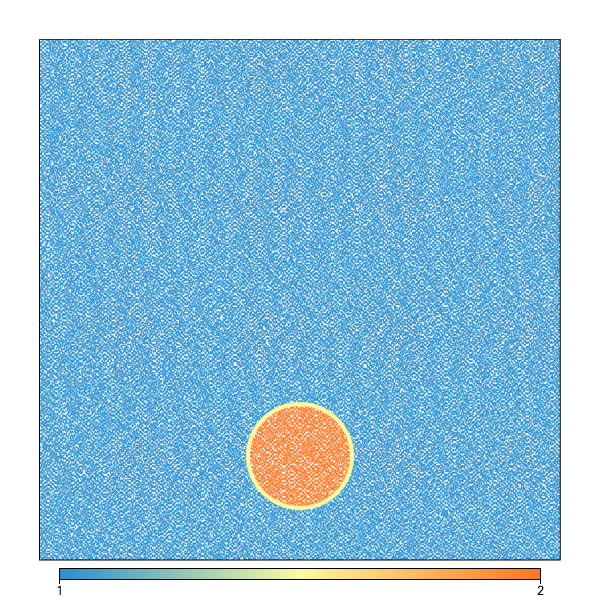

In [18]:
Fig = vis.Figure(figsize=(600,600))
Fig.Points(ball_contour, fn_size=5.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.save("Figure_3.png")
Fig.show()

In [19]:
Model.init_model()

In [20]:
Model.run_for(nstep=10, checkpoint_interval=1)

Running with UWGeodynamics version 2.10.0-dev-b0ccd70(new_examples)
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Step:     1 Model Time: 9.1 minute dt: 9.1 minute (2020-06-23 03:25:34)
Step:     2 Model Time: 17.9 minute dt: 8.9 minute (2020-06-23 03:25:36)
Step:     3 Model Time: 26.7 minute dt: 8.8 minute (2020-06-23 03:25:38)
Step:     4 Model Time: 35.4 minute dt: 8.7 minute (2020-06-23 03:25:40)
Step:     5 Model Time: 44.0 minute dt: 8.6 minute (2020-06-23 03:25:41)
Step:     6 Model Time: 52.4 minute dt: 8.5 minute (2020-06-23 03:25:43)
Step:     7 Model Time: 1.0 hour dt: 8.4 minute (2020-06-23 03:25:45)
Step:     8 Model Time: 1.2 hour dt: 8.3 minute (2020-06-23 03:25:46)
Step:     9 Model Time: 1.3 hour dt: 8.2 minute (2020-06-23 0

1


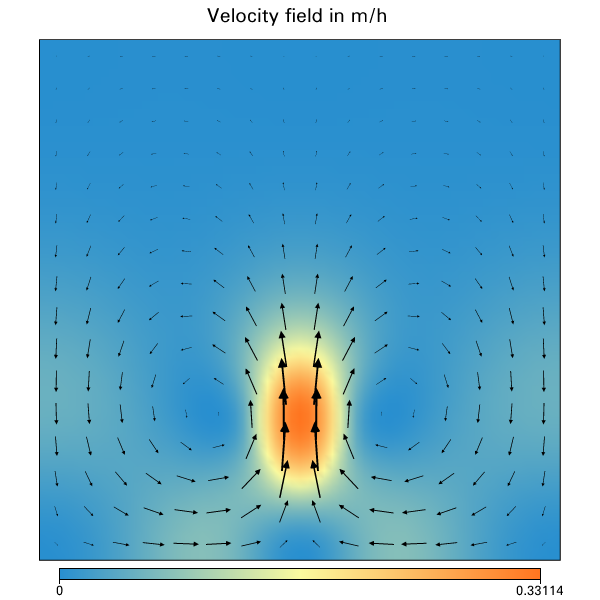

In [21]:
import underworld.function as fn
# Calculate the velocity magnitude
velocityMag = fn.math.dot(Model.velocityField, Model.velocityField)
# Get a conversion factor to units of m/hr
fact = GEO.dimensionalise(1.0, u.metre / u.hour).magnitude
# Apply the factor to the velocity Magnitude
velocityMag *= fact

Fig = vis.Figure(figsize=(600,600), title="Velocity field in m/h")
Fig.Points(ball_contour, colour="k")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_3.png")
Fig.show()